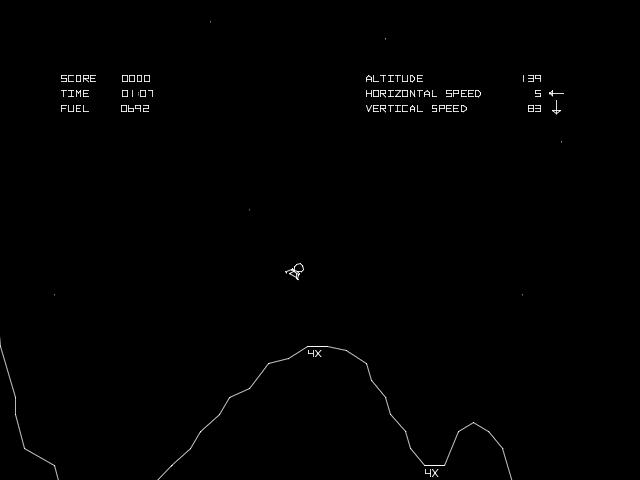

In this exercise we will use a (toy) problem to illustrate Reinforcement Learning, with a MLP neural network as our regressor.

The problem is inspired to a video game of the '80s, [Lunar Lander](https://en.wikipedia.org/wiki/Lunar_Lander_(video_game_genre)), in which you must pilot a rocket to land on a spot of the surface of the Moon, with an impact velocity that is not too high to avoid the crashing of the rocket. You only have **three commands: LEFT, RIGHT and UP**, that activate the corresponding thrusters of the rocket; **additionally, you can do nothing**.

We will not make a graphical user interface, limiting ourselves to a simulation model. We assume a bidimensional coordinate system, with coordinates in meters. 

**Success and fail conditions:**
*   The ground level is at y=0.
*   The landing spot is at (x, 0), with -5<= x <= +5.
*   Landing outside this spot will result in a crash.
*   Landing with a vertical velocity of more than 5 m/s will crash your rocket.

**Simulation model**
We assume:
*    a gravity acceleration of 1.5 m/s^2;
*    that the thusters can give a horizontal acceleration of 0.5 m/s^2 or a vertical acceleration of 2 m/s^2.

Our goal is to train a machine learning system, based on reinforcement learning, to make a safe lunar landing.

---



Connect the Notebook to a Google Drive account

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Now go to the appropriate folder on your google drive. Note: you may need to change the folder name, depending on where on your drive you have the data files.

In [ ]:
import os
os.chdir('/content/drive/My Drive/Didattica/Exercise10_reinforcemente_learning')

# The physical model of the lander

This class implements our physical model of the lunar lander. We assume that the state has 4 components: x, y, vx and vy. Also, we have 4 actions (NONE; LEFT; RIGHT; UP) represented by numbers 0 to 3.
A state update is performed every 50 milliseconds (of simulated time).

We compute the reward as follow:


*   +1000 in case of safe landing
*   -1000 in case of crash
*   -150 if the rocket takes too long (>100 seconds) before landing, or goes too far from the landing point
*   -0.01*(abs(x)+abs(y)) to penalize the rocket if it goes away from the landing point.



In [ ]:
import numpy as np
import random

STATE_VARIABLES = 4 # x, y, vx, vy
ACTIONS = 4
ACTIONS_NAMES=['None', 'Left', 'Right', 'Up']
ACTION_NONE = 0
ACTION_LEFT = 1
ACTION_RIGHT = 2
ACTION_UP = 3
DELTA_TIME = 0.05

class Lander:
  def __init__(self):
    self.reset()

  def reset(self):
    "(Re)Initialize the state information"
    self.x = 20.0*(random.random()-0.5)
    self.y = 10.0+random.random()*20.0
    self.vx = 0.0
    self.vy = 0.0
    self.time = 0.0

  def get_state(self):
    "Returns the Lander state"
    return np.array([self.x, self.y, self.vx, self.vy])

  def update(self, action, max_time=100.0):
    """Updates the state of the lander, given the current action.
       Returns a tuple:
          new_state, reward, finished
       where finished is True if the episode is finished"""
    ax = 0.0
    if action==ACTION_LEFT:
      ax = -0.5
    elif action==ACTION_RIGHT:
      ax = 0.5
    ay = -1.5
    if action==ACTION_UP:
      ay = 0.5
    self.vx += ax*DELTA_TIME
    self.vy += ay*DELTA_TIME
    self.x += self.vx*DELTA_TIME
    self.y += self.vy*DELTA_TIME
    self.time += DELTA_TIME

    # Stop the episode
    finished = False
    if self.y <= 0.0 or abs(self.x)>=100.0 or self.y>=100.0 or self.time>=max_time:
      finished=True
    
    # Success or fail
    crashed = False
    landed = False
    if self.y <=0.0:
      if abs(self.x)>=5.0 or self.vy <= -5.0:
        crashed = True
      else:
        landed = True
    
    # Assign the reward
    reward = 0.0
    if landed:
      reward += 1000.0
    elif crashed:
      reward += -1000.0
    elif finished:
      reward += -150.0
    reward += -0.01*(abs(self.x)+abs(self.y))

    # return state, reward and finished
    state=np.array([self.x, self.y, self.vx, self.vy])
    return state, reward, finished

## Visualize the environment

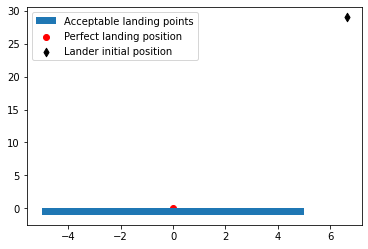

In [ ]:
from matplotlib import pyplot as plt

lander=Lander()

plt.gca().add_patch(plt.Rectangle((-5, -1), 10, 1))
plt.scatter(0, 0, c='r')
plt.scatter(lander.x, lander.y, marker='d', c='k')
plt.legend(['Acceptable landing points', 'Perfect landing position', 'Lander initial position'])

# The learning agent
This class implements our learning agent, based on the Q-Learning algorithm. We use a MLP with one hidden layer.

In [ ]:
from keras.models import Sequential
from keras.layers import Dense

HIDDEN_NODES = 64
GAMMA = 0.95

class Agent:
  def __init__(self):
    """Initialize the network with random weights.
    The network takes as input the state and output the Q-value for each action, separately."""
    self.net=Sequential()
    self.net.add(Dense(HIDDEN_NODES, activation='tanh', input_shape=(STATE_VARIABLES,)))
    self.net.add(Dense(ACTIONS))
    self.net.compile(optimizer='rmsprop', loss='mse')

  def save(self, fname):
    self.net.save_weights(fname)
  
  def load(self, fname):
    self.net.load_weights(fname)


  def evaluate_states(self, states):
    """states is a tensor with shape (batch_size, STATE_VARIABLES)"""
    return self.net.predict(states)

  def find_best_Q(self, states):
    """states is a tensor with shape (batch_size, STATE_VARIABLES)"""
    q = self.evaluate_states(states)
    return q.max(axis=1)

  def find_best_actions(self, states):
    """states is a tensor with shape (batch_size, STATE_VARIABLES)"""
    q = self.evaluate_states(states)
    return q.argmax(axis=1)

  def update_weights(self, states, actions, new_states, rewards):
    """states and new_states are tensors with shape (batch_size, STATE_VARIABLES)
       actions and rewards are arrays of batch_size elements
       
       This function takes as input a batch of states, decided actions and
       new states reached after that actions,
       computes q value and the new (target) q value using the Bellman equation,
       and performs one training iteration of the network that estimates the
       q values."""
    q = self.evaluate_states(states)
    newq = rewards + GAMMA*self.find_best_Q(new_states)  # Bellman equation
    n=q.shape[0]
    i=np.arange(n)
    q[i,actions]=newq
    self.net.train_on_batch(states, q)

  def choose_action(self, state):
    """states and new_states are tensors with shape (STATE_VARIABLES, )"""
    a=self.find_best_actions(state.reshape(1, STATE_VARIABLES))
    return a[0]



# Training on one episode at a time
This is the training algorithm for a single training episode. Executes the episode, collecting the states, actions and rewards, and at the end updates the weights of the agent with this information.

In [ ]:
def training_episode(lander, agent, error_rate=0.1):
  # initialization
  lander.reset()
  act=0
  finished=False
  states=[lander.get_state()]
  rewards=[]
  actions=[]

  # simulates one episode
  while not finished:
    # each cicle of this loop is one discrete time instant
    s,r,finished=lander.update(act)

    # store the action performed and the environment response to that action
    states.append(s)
    rewards.append(r)
    actions.append(act)

    # select the next action
    if random.random()<error_rate:
      act=random.randint(0, ACTIONS-1)  # random action (explore the environment to increase the knowledge)
    else:
      act=agent.choose_action(s)        # best action (exploit the knowledge learned so far)
  
  # update the network weights using the stored actions and environment responses
  new_states=np.array(states[1:])
  states=np.array(states[:-1])
  actions=np.array(actions)
  rewards=np.array(rewards)
  agent.update_weights(states, actions, new_states, rewards)
  print('Episode finished with reward=',r)

## The training loop
We create a new agent, and a new environment (lander):

In [ ]:
lander=Lander()
agent=Agent()

We run our training and save the model:




In [ ]:
for i in range(1000):
  print(i, end=' ')
  training_episode(lander, agent, 0.1)
  if i%50==49:
    agent.save('agent.model')
agent.save('agent.model')
print('Finished')

0 WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.
Episode finished with reward= -1000.0622764750847
1 Episode finished with reward= -1000.0430837490441
2 Episode finished with reward= -1000.0642819820728
3 Episode finished with reward= -1000.0469092055723
4 Episode finished with reward= -1000.041572080349
5 Episode finished with reward= 999.9668475821233
6 Episode finished with reward= -1000.0790471852905
7 Episode finished with reward= -1000.082470275315
8 Episode finished with reward= -1000.0484554580922
9 Episode finished with reward= -1000.0795227858272
10 Episode finished with reward= -1000.0881605584565
11 Episode finished with reward= -151.0845673975708


KeyboardInterrupt: ignored

## Evaluation
This reloads the saved model:

In [ ]:
lander=Lander()
agent=Agent()
agent.load('agent_bk.model')

The following code is used to plot a trajectory of a test episode:

In [ ]:
from matplotlib import pyplot as plt

def plot_episode(lander, agent, error_rate=0.0, max_time=100.0):
  lander.reset()
  act=0
  finished=False
  s=lander.get_state()
  x=[s[0]]
  y=[s[1]]
  while not finished:
    s,r,finished=lander.update(act, max_time=max_time)
    x.append(s[0])
    y.append(s[1])
    if random.random()<error_rate:
      act=random.randint(0, ACTIONS-1)
    else:
      act=agent.choose_action(s)
  print('Final state=', s)
  print('Final reward=', r)
  plt.gca().add_patch(plt.Rectangle((-5, -1), 10, 1))
  plt.scatter(0, 0, c='r')
  plt.scatter(x[0], y[0], marker='d', c='k')
  plt.plot(x,y)
  plt.legend(['Lander path', 'Acceptable landing points', 'Perfect landing position', 'Lander initial position'])

Final state= [-3.40600886 -0.12488465  1.275      -8.375     ]
Final reward= -1000.0353089351257


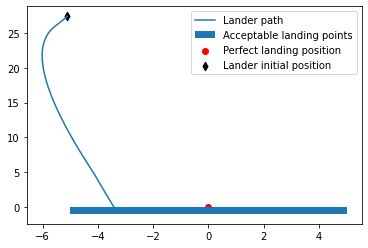

In [ ]:
plot_episode(lander,agent)

# Training with a Replay Buffer
A common problem with Reinforcement Learning is that the data collected from a single episode are highly correlated, and so they may create problems to the learning algorithm.

A way for avoiding this is to use a **replay buffer**: a data structure in which we accumulate the data of several episodes, and after each episode we extract at random data from the buffer to update the weights.

In the following we implement this modification to the algorithm: the class ReplayBuffer implements the buffer data structure, and the function training_episode_with_replay implements the training with the use of this structure.

In [ ]:
MAX_BUFFER=20000

class ReplayBuffer:
  def __init__(self):
    self.states=np.empty((0, STATE_VARIABLES))
    self.actions=np.empty((0,), dtype=np.int32)
    self.new_states=np.empty((0, STATE_VARIABLES))
    self.rewards=np.empty((0,))

  def get_size(self):
    return self.states.shape[0]

  def append(self, states, actions, new_states, rewards):
    self.states=np.concatenate((self.states, states))[-MAX_BUFFER:]
    self.actions=np.concatenate((self.actions, actions))[-MAX_BUFFER:]
    self.new_states=np.concatenate((self.new_states, new_states))[-MAX_BUFFER:]
    self.rewards=np.concatenate((self.rewards, rewards))[-MAX_BUFFER:]

  def sample(self, n):
    k=self.states.shape[0]
    idx=np.random.randint(0,k-1, size=(n,))
    return self.states[idx], self.actions[idx], self.new_states[idx], self.rewards[idx]


replay_buffer=ReplayBuffer()
BATCH_SIZE=128

def training_episode_with_replay(lander, agent, error_rate=0.1, learning_cycles=1):
  lander.reset()
  act=0
  finished=False
  states=[lander.get_state()]
  rewards=[]
  actions=[]
  while not finished:
    s,r,finished=lander.update(act)
    states.append(s)
    rewards.append(r)
    actions.append(act)
    if random.random()<error_rate:
      act=random.randint(0, ACTIONS-1)
    else:
      act=agent.choose_action(s)
  new_states=np.array(states[1:])
  states=np.array(states[:-1])
  actions=np.array(actions)
  rewards=np.array(rewards)
  replay_buffer.append(states, actions, new_states, rewards)
  for _ in range(learning_cycles):
    states, actions, new_states, rewards=replay_buffer.sample(BATCH_SIZE)
    agent.update_weights(states, actions, new_states, rewards)
  print('Episode finished with reward=',r)
  

## The training loop

In [ ]:
lander=Lander()
agent=Agent()

In [ ]:
for i in range(1000):
  print(i, end=' ')
  training_episode_with_replay(lander, agent, error_rate=0.05, learning_cycles=64)
  if i%100 == 99:
    agent.save('agent2.model')
    print('Saved model')
agent.save('agent2.model')
print('Finished')

0 Episode finished with reward= -1000.0115651790327
1 Episode finished with reward= -1000.0200237326591
2 Episode finished with reward= -1000.0186606689055
3 

KeyboardInterrupt: ignored

In [ ]:
replay_buffer.get_size()

315

##Evaluation

In [ ]:
lander=Lander()
agent=Agent()
agent.load('agent2_bk.model')

Final state= [-6.59381645  3.98990303 -0.075       0.025     ]
Final reward= -150.10583719486013


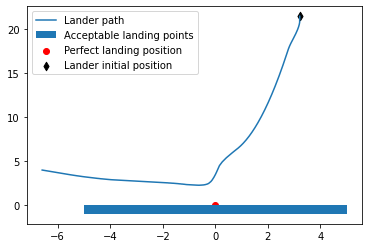

In [ ]:
plot_episode(lander,agent)